<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/cat_and_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Utilities to upload files
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


In [0]:
#Authorize Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#download train and test images
download = drive.CreateFile({'id': '1EVPUykY4KwHvWL-umtLhJIfGhCFtHqn8'})
download.GetContentFile('train.zip')
download = drive.CreateFile({'id': '1l4vKliu1LB5Y65ZMvsSDrJiPG2mKvdqN'})
download.GetContentFile('test1.zip')

#Extract files
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('tmp')
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [0]:
def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

In [0]:
TRAININNG_DIRECTORY='tmp/train'
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

df = pd.DataFrame({'filename': os.listdir(TRAININNG_DIRECTORY)})

df['category'] = df['filename'].map(lambda file_name: file_name.split('.')[0])
df['Y'] = df['category'].map(lambda x: np.array([0,1]) if x =='cat' else np.array([1,0]))
df['X'] = df['filename'].map(lambda file: get_im_cv2(TRAININNG_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

In [0]:
#build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop
model = Sequential()

## Might need to add batch normalization after activation??? https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()
#df.head()

,filename,category,Y,X
0,dog.11642.jpg,dog,"[1, 0]","[[[58, 55, 56], [26, 21, 27], [46, 40, 49], [5..."
1,cat.3292.jpg,cat,"[0, 1]","[[[163, 161, 181], [165, 163, 183], [164, 162,..."
2,cat.4147.jpg,cat,"[0, 1]","[[[137, 142, 145], [153, 159, 161], [150, 155,..."
3,dog.9444.jpg,dog,"[1, 0]","[[[221, 238, 250], [165, 193, 204], [170, 204,..."
4,cat.2017.jpg,cat,"[0, 1]","[[[7, 8, 6], [7, 8, 6], [7, 8, 6], [8, 9, 6], ..."


In [0]:
#Build Alex Net
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD

# Here, we use a larger 11 x 11 window to capture objects. At the same time,
# we use a stride of 4 to greatly reduce the height and width of the output.
# Here, the number of output channels is much larger than that in LeNet
model = Sequential([
                    Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=3, strides=2, padding='valid'),
                    Conv2D(256, kernel_size=5, padding='valid', strides=1 ,activation='relu'),
                    MaxPooling2D(pool_size=3, strides=2, padding='valid'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    Conv2D(384, kernel_size=3, padding='valid', strides=1, activation='relu'),
                    MaxPooling2D(pool_size=3, strides=2),
                    Flatten(),
                    #Dense(4096, activation="relu"), 
                    #BatchNormalization(),
                    #Dropout(0.5),
                    Dense(4096, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(2, activation='softmax')])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=30
BATCH_SIZE=15
callbacks = [learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    ,callbacks=callbacks)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 34s 2ms/step - loss: 0.7246 - acc: 0.6440 - val_loss: 0.6358 - val_acc: 0.6500
Epoch 2/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.4638 - acc: 0.7855 - val_loss: 0.4549 - val_acc: 0.7814
Epoch 3/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3874 - acc: 0.8303 - val_loss: 0.8898 - val_acc: 0.6896
Epoch 4/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3366 - acc: 0.8591 - val_loss: 0.4363 - val_acc: 0.7980
Epoch 5/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.2936 - acc: 0.8782 - val_loss: 0.3320 - val_acc: 0.8546
Epoch 6/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.2753 - acc: 0.8859 - val_loss: 0.3484 - val_acc: 0.8528
Epoch 7/30
20000/20000 [==============================] - 27s 1ms/step - loss: 0.2601 - acc: 0.8961 - val_loss: 0.6009 - val_acc:

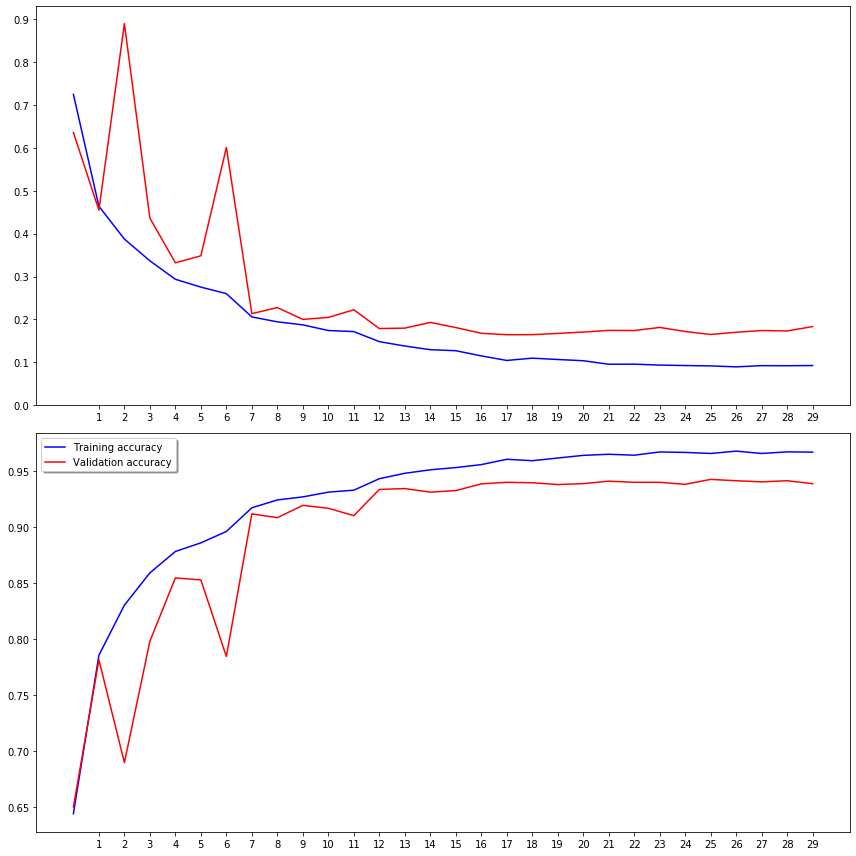

In [0]:
#Plot the loss
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
TEST_DIRECTORY = 'tmp/test1'
test_data_frame = pd.DataFrame({'filename': os.listdir(TEST_DIRECTORY)})

#df['category'] = df['filename'].map(lambda file_name: file_name.split('.')[0])
#df['Y'] = df['category'].map(lambda x: np.array([1,0])if x !='cat' else np.array([0,1]))
test_data_frame['X'] = test_data_frame['filename'].map(lambda file: get_im_cv2(TEST_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

In [0]:
x_perf=[]
for item in test_data_frame['X']:
  x_perf.append(item)

x_perf = np.array(x_perf, dtype=np.uint8)
predict = model.predict(x_perf)

In [0]:
print(predict[0])
print(predict[1])
print(predict[2])
test_data_frame['category'] = np.argmax(predict, axis=1)
label_map = { 0:'dog', 1:'cat'}
test_data_frame['animal'] = test_data_frame['category'].map(lambda x: label_map.get(x))
test_data_frame.head()

[0.9969158  0.00308417]
[9.9984694e-01 1.5305047e-04]
[7.469622e-09 1.000000e+00]


,filename,X,category,animal
0,12200.jpg,"[[[114, 149, 181], [117, 153, 186], [117, 152,...",0,dog
1,7209.jpg,"[[[189, 153, 147], [193, 157, 151], [192, 156,...",0,dog
2,2620.jpg,"[[[30, 44, 46], [42, 52, 56], [48, 57, 64], [4...",1,cat
3,9457.jpg,"[[[18, 23, 22], [10, 16, 14], [10, 15, 13], [1...",1,cat
4,8185.jpg,"[[[44, 72, 83], [38, 66, 77], [34, 64, 75], [2...",0,dog


ValueError: ignored

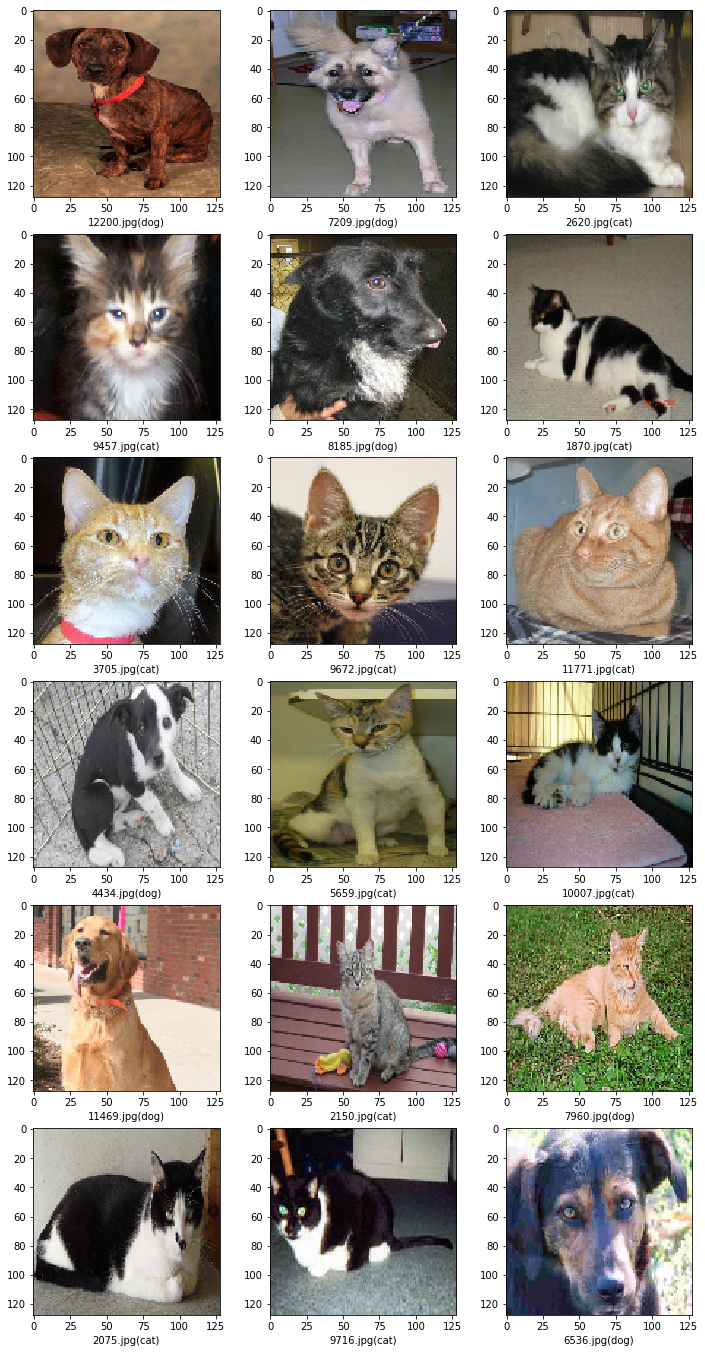

In [0]:
#Draw predictions with images
from keras.preprocessing.image import load_img
sample_test = test_data_frame.head(19)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['animal']
    img = load_img("tmp/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()